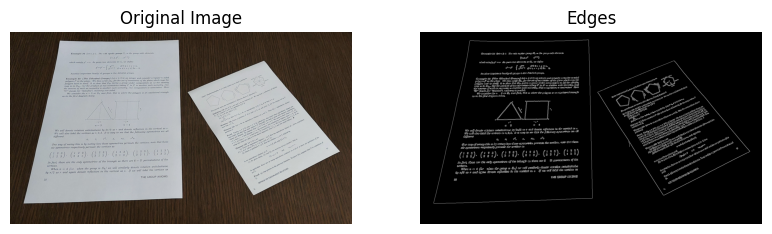

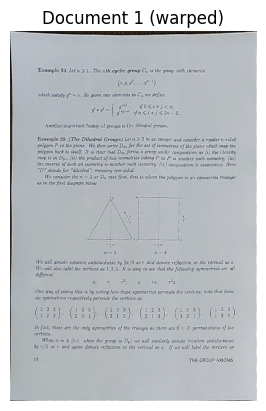

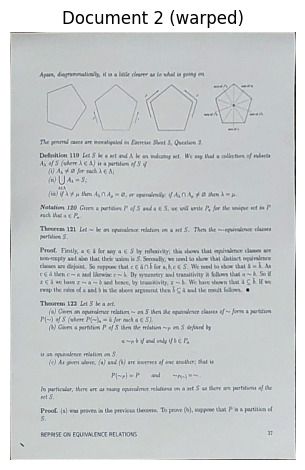

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def reorder_corners(corners):
    if corners.shape[0] == 4 and corners.shape[1] == 1:
        corners = corners.reshape((4, 2))

    rect = np.zeros((4, 2), dtype=np.float32)

    s = corners.sum(axis=1)
    diff = np.diff(corners, axis=1)

    rect[0] = corners[np.argmin(s)]
    rect[2] = corners[np.argmax(s)]
    rect[1] = corners[np.argmin(diff)]
    rect[3] = corners[np.argmax(diff)]

    return rect

def warp_document(image, corner_pts, w=400, h=600):
    src_rect = reorder_corners(corner_pts)

    dst_rect = np.array([
        [0,    0],
        [w-1,  0],
        [w-1,  h-1],
        [0,    h-1]
    ], dtype=np.float32)

    M = cv2.getPerspectiveTransform(src_rect, dst_rect)

    warped = cv2.warpPerspective(image, M, (w, h))
    return warped

def scan_documents(input_path):
    original = cv2.imread(input_path)
    if original is None:
        raise IOError(f"Could not open {input_path}")

    img_color = original.copy()
    img_gray  = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

    img_blur  = cv2.GaussianBlur(img_gray, (5,5), 0)
    edges     = cv2.Canny(img_blur, 50, 150)

    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    doc_corners_list = []

    for c in contours:
        area = cv2.contourArea(c)
        if area < 1000:
            continue

        epsilon = 0.02 * cv2.arcLength(c, True)
        approx  = cv2.approxPolyDP(c, epsilon, True)

        if len(approx) == 4:
            doc_corners_list.append(approx)

    warped_docs = []
    for doc_corners in doc_corners_list:
        warped = warp_document(img_color, doc_corners, w=400, h=600)
        warped_docs.append(warped)

    return img_color, edges, warped_docs

if __name__ == "__main__":
    input_image = "Doc.jpg"
    color_img, edge_img, docs = scan_documents(input_image)

    plt.figure(figsize=(15, 8))

    plt.subplot(131)
    plt.imshow(cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(edge_img, cmap='gray')
    plt.title("Edges")
    plt.axis('off')

    if len(docs) > 0:
        for i, doc_img in enumerate(docs):
            plt.figure()
            plt.imshow(cv2.cvtColor(doc_img, cv2.COLOR_BGR2RGB))
            plt.title(f"Document {i+1} (warped)")
            plt.axis('off')
    else:
        plt.subplot(133)
        plt.title("No documents found!")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Detected pipes: 182


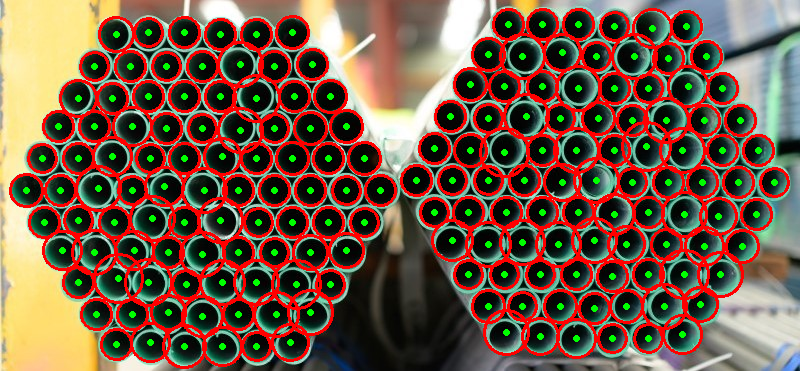

In [15]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def detect_and_count_pipes(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found. Please check the path.")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray_clahe = clahe.apply(gray)

    gray_clahe = cv2.medianBlur(gray_clahe, 5)


    circles = cv2.HoughCircles(
        gray_clahe,
        method=cv2.HOUGH_GRADIENT,
        dp=1.0,
        minDist=14,
        param1=60,
        param2=28,
        minRadius=10,
        maxRadius=30
    )

    output = img.copy()
    count = 0

    if circles is not None:
        circles = np.uint16(np.around(circles[0]))
        for (x, y, r) in circles:
            cv2.circle(output, (x, y), r, (0, 0, 255), 2)
            cv2.circle(output, (x, y), 2, (0, 255, 0), 2)
        count = len(circles)

    print("Detected pipes:", count)
    cv2_imshow(output)

detect_and_count_pipes("Pipes.jpg")
